In [10]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.combine import SMOTETomek

print("All libraries loaded")

All libraries loaded


In [15]:
try:
    data = pd.read_csv('informacion_completa_imagenes_V2.csv')
    print("Datos cargados exitosamente.")
except Exception as e:
    print(f"Error al cargar los datos: {e}")
    
print(data.info())

print(data.columns)


Datos cargados exitosamente.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nombre de la imagen               226 non-null    object 
 1   Ángulo entre manecillas           226 non-null    float64
 2   Ángulo manecillas 2pm             226 non-null    float64
 3   Ángulo manecillas 11am            226 non-null    float64
 4   Lowest point                      226 non-null    object 
 5   longitud_manecilla_2pm            226 non-null    float64
 6   longitud_manecilla_11am           226 non-null    float64
 7   Números detectados correctamente  226 non-null    int64  
 8   Números con error espacial        226 non-null    int64  
 9   Números algo detectado            226 non-null    int64  
 10  Total numeros detectados          226 non-null    int64  
 11  Puntuacion contorno               226 non-

In [16]:
data = data.astype({col: 'float64' for col in data.select_dtypes(include='bool').columns})
data[['lowest_point_x', 'lowest_point_y']] = data['Lowest point'].str.strip('()').str.split(',', expand=True).astype(float)
data['longitud_relativa_2pm'] = data['longitud_manecilla_2pm' ] / data['Area Circulo']
data['longitud_relativa_11pm'] = data['longitud_manecilla_11am' ] / data['Area Circulo']

data = data[data['Tipo'] != 'PR']
data.dropna(subset=['Tipo'], inplace=True)

data.drop(columns=['nombre de la imagen','longitud_manecilla_2pm','longitud_manecilla_11am','Lowest point','Tipo'],inplace=True)


data['TipoDeDiagnostico'] = data['Diagnostico '].map({'CN': 1, 'MCI': 2, 'PDD': 3})
data.drop(columns=['Diagnostico '], inplace=True)

data = data.dropna()

conteo_clases = data['TipoDeDiagnostico'].value_counts()

print(conteo_clases)
print(data.info())

TipoDeDiagnostico
1    128
3     35
2     33
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 225
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ángulo entre manecillas           196 non-null    float64
 1   Ángulo manecillas 2pm             196 non-null    float64
 2   Ángulo manecillas 11am            196 non-null    float64
 3   Números detectados correctamente  196 non-null    int64  
 4   Números con error espacial        196 non-null    int64  
 5   Números algo detectado            196 non-null    int64  
 6   Total numeros detectados          196 non-null    int64  
 7   Puntuacion contorno               196 non-null    int64  
 8   Puntuacion manecillas             196 non-null    int64  
 9   Puntuacion numeros                196 non-null    int64  
 10  puntuacion final                  196 non-null    int64  
 11  Area 

In [18]:
from sklearn.preprocessing import OneHotEncoder

X = data.drop(columns=['TipoDeDiagnostico'])
y = data['TipoDeDiagnostico']

X = X.dropna()
y = y[X.index]

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

print(X.info())
print(y.info())

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 225
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ángulo entre manecillas           196 non-null    float64
 1   Ángulo manecillas 2pm             196 non-null    float64
 2   Ángulo manecillas 11am            196 non-null    float64
 3   Números detectados correctamente  196 non-null    int64  
 4   Números con error espacial        196 non-null    int64  
 5   Números algo detectado            196 non-null    int64  
 6   Total numeros detectados          196 non-null    int64  
 7   Puntuacion contorno               196 non-null    int64  
 8   Puntuacion manecillas             196 non-null    int64  
 9   Puntuacion numeros                196 non-null    int64  
 10  puntuacion final                  196 non-null    int64  
 11  Area Circulo                      196 non-null    float64
 12  Circularidad 

Datos de entrenamiento: (166, 21), Datos de validación: (72, 21), Datos de prueba ciega: (40, 21)


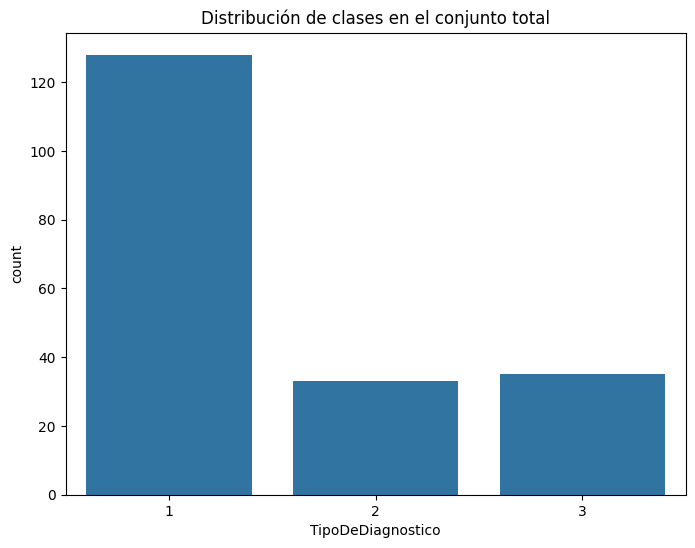

TipoDeDiagnostico
1    128
3     35
2     33
Name: count, dtype: int64


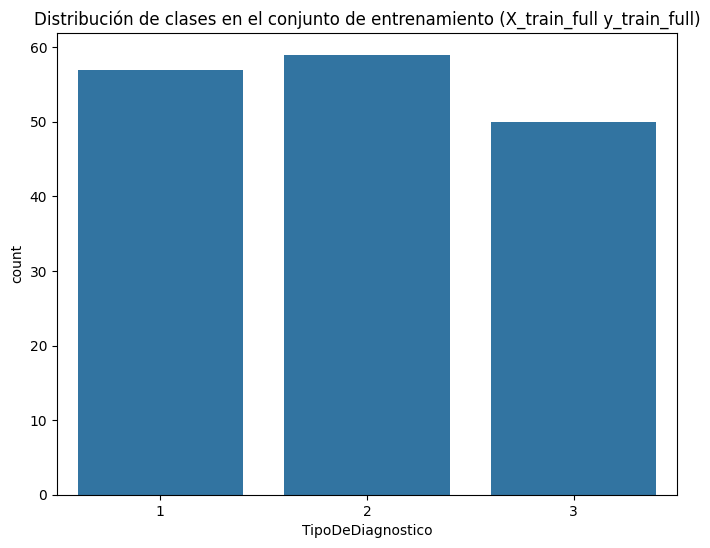

TipoDeDiagnostico
2    59
1    57
3    50
Name: count, dtype: int64


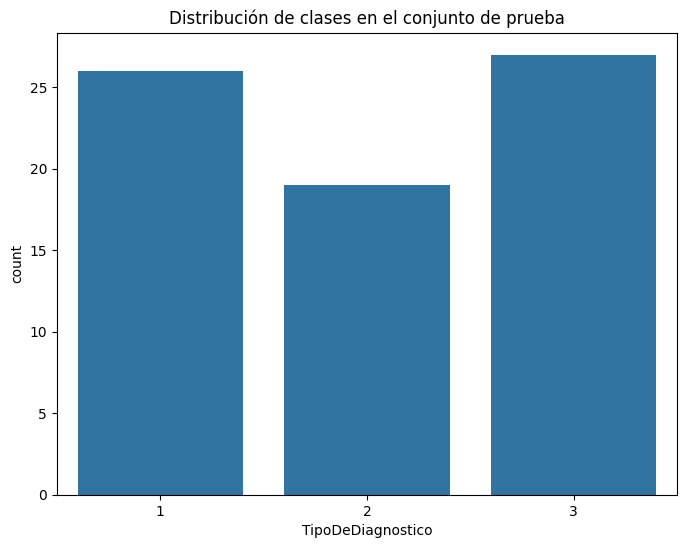

TipoDeDiagnostico
3    27
1    26
2    19
Name: count, dtype: int64


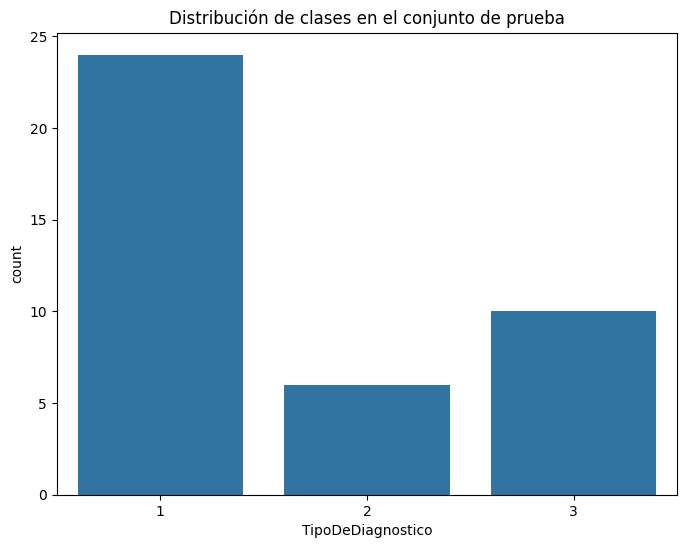

TipoDeDiagnostico
1    24
3    10
2     6
Name: count, dtype: int64


In [19]:
X_train, X_test_blind, y_train, y_test_blind = train_test_split(X, y, test_size=0.2, random_state=42)  

smote = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


print(f"Datos de entrenamiento: {X_train_full.shape}, Datos de validación: {X_test_full.shape}, Datos de prueba ciega: {X_test_blind.shape}")

plt.figure(figsize=(8,6))
sns.countplot(x=y)
plt.title('Distribución de clases en el conjunto total')
plt.show()
print(y.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_train_full)
plt.title('Distribución de clases en el conjunto de entrenamiento (X_train_full y_train_full)')
plt.show()
print(y_train_full.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_test_full)
plt.title('Distribución de clases en el conjunto de prueba')
plt.show()
print(y_test_full.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_test_blind)
plt.title('Distribución de clases en el conjunto de prueba')
plt.show()
print(y_test_blind.value_counts())

In [21]:
param_grid = {
    'classifier__n_estimators': [200, 400, 600],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [4, 6, 10],
    'classifier__min_samples_leaf': [2, 4, 6],
    'classifier__bootstrap': [True],
    'classifier__max_samples': [0.7, 0.8, 0.9],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_features': ['sqrt'],
    'classifier__oob_score': [True],
    'classifier__warm_start': [False]
}

In [22]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf)
])


random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=50, 
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    scoring='f1' 
)

In [23]:
random_search.fit(X_train_full, y_train_full)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\victo\UDEM\entornosVirtuales\PEF\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['Ángulo entre manecillas', 'Ángulo manecillas 2pm',
       'Ángulo manecillas 11am', 'Números detectados correctamente',
       'Números con error espacial', 'Números algo detectado',
       'Total numeros detectados', 'Puntuacion conto...
                                                                  'entropy'],
                                        'classifier__max_depth': [10, 20, 30,
                                                                  None],
                                        'classifier__max_features': ['sqrt'],
                                        'classifier__max_samples': [0.7, 0.8,
                                                                    0.9],
                                        'classifier__min_samples_leaf': [2, 4,
                                                                         6],
                                        'classifier__min_samples_split': [4, 6,
                                                                          10],
                                        'classifier__n_estimators': [200, 400,
                                                                     600],
                                        'classifier__oob_score': [True],
                                        'classifier__warm_start': [False]},
                   random_state=42, scoring='f1', verbose=2)

In [24]:
y_val_pred = random_search.predict(X_test_full)

print("Evaluación en el conjunto de validación:")
print(f"Accuracy: {accuracy_score(y_test_full, y_val_pred):.4f}")
print(f"Precision: {precision_score(y_test_full, y_val_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_full, y_val_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test_full, y_val_pred, average='weighted'):.4f}")
print("\nReporte de clasificación:\n" + classification_report(y_test_full, y_val_pred))


Evaluación en el conjunto de validación:
Accuracy: 0.8750
Precision: 0.8808
Recall: 0.8750
F1 Score: 0.8756

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.91      0.81      0.86        26
           2       0.77      0.89      0.83        19
           3       0.93      0.93      0.93        27

    accuracy                           0.88        72
   macro avg       0.87      0.88      0.87        72
weighted avg       0.88      0.88      0.88        72



In [28]:
y_test_blind_pred = random_search.best_estimator_.predict(X_test_blind)
print("Evaluación en conjunto de prueba ciega:")
print(f"Accuracy: {accuracy_score(y_test_blind, y_test_blind_pred):.4f}")
print(f"Precision: {precision_score(y_test_blind, y_test_blind_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_blind, y_test_blind_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test_blind, y_test_blind_pred, average='weighted'):.4f}")


Evaluación en conjunto de prueba ciega:
Accuracy: 0.5750
Precision: 0.6396
Recall: 0.5750
F1 Score: 0.6037


In [30]:
y_test_pred = random_search.best_estimator_.predict(X_train)
print("Evaluación en conjunto train original:")
print(f"Accuracy: {accuracy_score(y_train, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_test_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_train, y_test_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_train, y_test_pred, average='weighted'):.4f}")


Evaluación en conjunto train original:
Accuracy: 0.8782
Precision: 0.8871
Recall: 0.8782
F1 Score: 0.8801


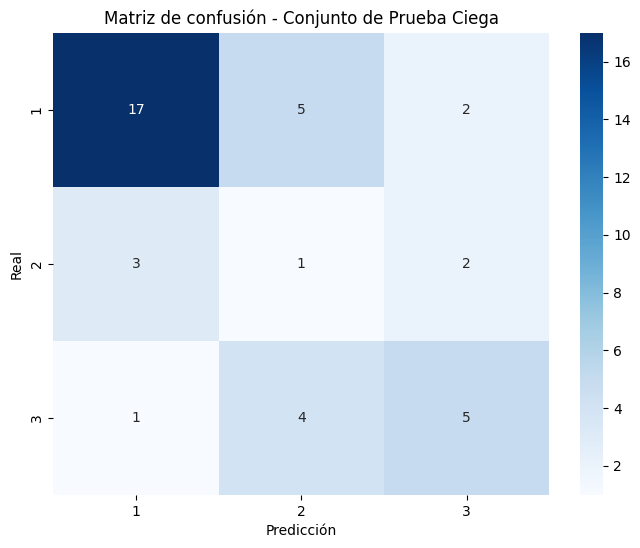

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_blind, y_test_blind_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Prueba Ciega')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


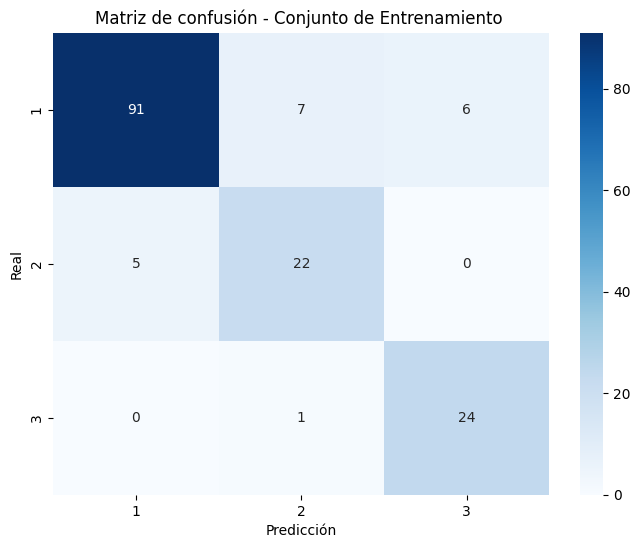

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_train, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Entrenamiento ')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()
